# Random Forest
Total dataset size: 127 samples <br>
Training set: 95 samples <br>
Testing set: 32 samples

Features used:
- LTA precipitation (mmpa)
- LTA WD (days)
- LTA PET (mm)
- Aridity idx
- LTA NDVI idx
- LTA soil moisture - 10cm (kgm-2)
- Aquifer group (cat.)
- Soil group (cat.)
- Landcover (cat.)

In [1]:
import pandas as pd
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
%matplotlib inline
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import rasterio
from utils import getAllCoordinates

# read file (data + coordinates)
file = pd.read_csv('poc.csv')
# OMIT ZERO RECHARGE SAMPLES
file = file[file['Recharge_mmpa']!= 0.1]
#file = file[file['Recharge_mmpa'] < 800]

# extract data only for one-hot encoding
data = file.drop(columns=['Lat', 'Long', 'ID', 'Landcover', 'SM10_kgm2', 'LTA_WD_days'])
data

,Recharge_mmpa,LTA_P_mmpa,LTA_PET_mm,Aridity,NDVI,Aquifer_group,Soil_group,Landcover_ext,DEM,SM10_m3m3
0,253.0,1234.743356,1265.000000,0.977426,0.548899,Basement,LX,130,360,0.317942
1,22.0,555.876675,1386.030028,0.403442,0.417538,Basement,AC,30,1039,0.210401
2,245.0,1376.716688,1337.440024,1.029575,0.687945,Basement,NT,30,1125,0.312940
3,185.0,518.196676,1590.610029,0.326188,0.268559,Sedimentary,LP,200,1657,0.229384
4,120.0,1344.580024,1298.693353,1.038857,0.593882,Sedimentary,NT,30,26,0.330358
...,...,...,...,...,...,...,...,...,...,...
129,100.0,655.280013,1356.070025,0.486649,0.403724,Sedimentary,LP,30,1376,0.323871
130,80.0,816.720013,1266.233355,0.648767,0.479056,Basement,CM,130,1382,0.227937
131,8.0,510.140009,1922.536704,0.265403,0.327490,Unconsolidated,GL,14,28,0.194245
132,160.0,1215.073356,1149.026683,1.058098,0.447078,Sedimentary,LP,20,2482,0.279276


In [2]:
# One-hot encode the data using pandas get_dummies
# TODO: use Label Encoder instead and check if the model performs better
# https://towardsdatascience.com/one-hot-encoding-is-making-your-tree-based-ensembles-worse-heres-why-d64b282b5769
#data = pd.get_dummies(data)
labelencoder = LabelEncoder()
data['Aquifer_group_cat'] = labelencoder.fit_transform(data['Aquifer_group'])
data['Soil_group_cat'] = labelencoder.fit_transform(data['Soil_group'])
# work with class codes instead of descriptions
#data['Landcover_cat'] = labelencoder.fit_transform(data['Landcover_ext'])

# # remove categorical variables
data = data.drop('Aquifer_group', axis = 1)
data = data.drop('Soil_group', axis = 1)
#data = data.drop('Landcover_ext', axis = 1)

data

,Recharge_mmpa,LTA_P_mmpa,LTA_PET_mm,Aridity,NDVI,Landcover_ext,DEM,SM10_m3m3,Aquifer_group_cat,Soil_group_cat
0,253.0,1234.743356,1265.000000,0.977426,0.548899,130,360,0.317942,0,12
1,22.0,555.876675,1386.030028,0.403442,0.417538,30,1039,0.210401,0,0
2,245.0,1376.716688,1337.440024,1.029575,0.687945,30,1125,0.312940,0,13
3,185.0,518.196676,1590.610029,0.326188,0.268559,200,1657,0.229384,1,10
4,120.0,1344.580024,1298.693353,1.038857,0.593882,30,26,0.330358,1,13
...,...,...,...,...,...,...,...,...,...,...
129,100.0,655.280013,1356.070025,0.486649,0.403724,30,1376,0.323871,1,10
130,80.0,816.720013,1266.233355,0.648767,0.479056,130,1382,0.227937,0,4
131,8.0,510.140009,1922.536704,0.265403,0.327490,14,28,0.194245,2,8
132,160.0,1215.073356,1149.026683,1.058098,0.447078,20,2482,0.279276,1,10


In [3]:
# Labels are the values we want to predict
#labels = data['Recharge_mmpa']
labels = np.log10(data['Recharge_mmpa'])
# Remove the labels from the features
data = data.drop('Recharge_mmpa', axis = 1)
# Saving feature names for later use
feature_list = list(data.columns)
# Convert to numpy array
features = np.array(data)

In [ ]:
n_bins = 10

fig, axs = plt.subplots(1,2, figsize=(15,5))
axs = axs.flatten()
# We can set the number of bins with the `bins` kwarg
axs[0].hist(labels, bins=n_bins)
axs[0].set_title('Distribution of observed recharge')
axs[0].set_xlabel('Observed recharge')
axs[0].set_ylabel('Number of observations')

# axs[1].hist(np.log10(labels), bins=n_bins)
# axs[1].set_title('Distribution of observed recharge (scaled) ')
# axs[1].set_xlabel('Observed recharge (log10) ')
# axs[1].set_ylabel('Number of observations')

 # Experiment 1: 100 runs for reliable importance measure

In [ ]:
importances = []
best_model = None
best_r2 = 0
best_importances = None
best_train_features, best_test_features, best_train_labels, best_test_labels = None, None, None, None
train_r2=[]
test_r2=[]
oobs=[]
train_r2_untransf=[]
test_r2_untransf=[]
best_rmse = 300
# run model 100 times
for i in range(0,100):
    # Split the data into training and testing sets
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.3)    
    # Instantiate models with 2000 decision trees
    rf = RandomForestRegressor(n_estimators = 2000, max_features=0.33, oob_score=True)
    
    # Train the model on training data
    rf.fit(train_features, train_labels)
    
    # Use the forest's predict method on the test data
    predictions = rf.predict(test_features)
    train_predictions = rf.predict(train_features)
    current_r2 = metrics.r2_score(test_labels, predictions)
    current_train_r2 = metrics.r2_score(train_labels, train_predictions)
    
    train_r2.append(current_train_r2)
    test_r2.append(current_r2)
    train_r2_untransf.append(metrics.r2_score(10**train_labels, 10**train_predictions))
    test_r2_untransf.append(metrics.r2_score(10**test_labels, 10**predictions))
    oobs.append(rf.oob_score_)
    print(f'Out-of-bag score estimate: {rf.oob_score_:>5.3}; Train R-2: {current_train_r2:>5.3}, Test R-2: {current_r2:>5.3}')

    current_rmse = metrics.mean_squared_error(10**test_labels, 10**predictions, squared=False)
    print(f"current rmse {current_rmse}")
    if current_rmse<best_rmse:
        best_rmse = current_rmse
        best_r2 = current_r2
        best_model = rf
        best_importances = rf.feature_importances_
        best_train_features, best_test_features, best_train_labels, best_test_labels = train_features, test_features, train_labels, test_labels
    importances.append(rf.feature_importances_)

In [ ]:
best_predictions = best_model.predict(best_test_features)
# Use the forest's predict method on the training data
best_train_predictions = best_model.predict(best_train_features)

print("+++ METRICS ON LOG-TRANSFORMED VALUES +++")
print(f"Max R2 train: {np.array(train_r2).max()}")
print(f"Min R2 train: {np.array(train_r2).min()}")
print(f"Mean R2 train: {np.array(train_r2).mean()}")
print(f'Best RMSE train: {metrics.mean_squared_error(10**best_train_labels, 10**best_train_predictions, squared=False)}\n')

print(f"Max oob: {np.array(oobs).max()}")
print(f"Min oob: {np.array(oobs).min()}")
print(f"Mean oob: {np.array(oobs).mean()}\n")

print(f"Max R2 test: {np.array(test_r2).max()}")
print(f"Min R2 test: {np.array(test_r2).min()}")
print(f"Mean R2 test: {np.array(test_r2).mean()}")
print(f'Best RMSE test: {metrics.mean_squared_error(10**best_test_labels, 10**best_predictions, squared=False)}\n')

print("+++ METRICS ON BACK TRANSFORMED VALUES +++")
print(f"Max R2 train: {np.array(train_r2_untransf).max()}")
print(f"Min R2 train: {np.array(train_r2_untransf).min()}")
print(f"Mean R2 train: {np.array(train_r2_untransf).mean()}\n")
print(f"Max R2 test: {np.array(test_r2_untransf).max()}")
print(f"Min R2 test: {np.array(test_r2_untransf).min()}")
print(f"Mean R2 test: {np.array(test_r2_untransf).mean()}")

In [ ]:
print("+++ Best model metrics +++\n")
print("--- log transformed ---")
print(f'Out-of-bag R-2 score estimate: {best_model.oob_score_:>5.3}')
print('Best R2 train: ', best_model.score(best_train_features, best_train_labels))
print(f'Best R2 test:  {best_model.score(best_test_features, best_test_labels)}\n')
print("--- back transformed ---")
print(f'Best RMSE train: {metrics.mean_squared_error(10**best_train_labels, 10**best_train_predictions, squared=False)}')
print(f"Best RMSE test: {best_rmse}")
print(f"Best R2 train: {metrics.r2_score(10**best_train_labels, 10**best_train_predictions)}")
print(f"Best R2 test: {metrics.r2_score(10**best_test_labels, 10**best_predictions)}")

In [ ]:
importances = np.array(importances)
mean_importances = np.mean(importances, axis=0)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, mean_importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
print('Mean feature importance')
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

In [ ]:
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, best_importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances
print('Best performing model: feature importance')
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

In [ ]:
feature_names = [f[0] for f in feature_importances]
y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots()
ax.barh(y_ticks, [f[1] for f in feature_importances])
ax.set_yticks(y_ticks)
ax.set_yticklabels(feature_names)
ax.set_title("Random Forest Feature Importances")
fig.tight_layout()
plt.show()

## Discourse: MANUAL FEATURE IMPORTANCE ASSESSMENT
code from https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html

#### Permutation importance

In [ ]:
from sklearn.inspection import permutation_importance
feature_names = data.columns

# permutation importance on training set
result_train = permutation_importance(best_model, best_train_features, best_train_labels, n_repeats=30,
                                random_state=42)
perm_sorted_idx = result_train.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(best_model.feature_importances_)
tree_indices = np.arange(0, len(best_model.feature_importances_)) + 0.5

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
ax1.barh(tree_indices,
         best_model.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_title('Random forest feature importance')
ax1.set_ylabel('Feature name')
ax1.set_xlabel('Relative feature importance')
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(feature_names[tree_importance_sorted_idx])
ax1.set_ylim((0, len(best_model.feature_importances_)))
ax2.boxplot(result_train.importances[perm_sorted_idx].T, vert=False,
            labels=feature_names[tree_importance_sorted_idx])
ax2.set_title('Permutation importance (train set)')
ax2.set_ylabel('Feature name')
ax2.set_xlabel('Relative feature importance')

# permutation importance on test set
result_test = permutation_importance(best_model, best_test_features, best_test_labels, n_repeats=10,
                                random_state=42)

perm_sorted_idx = result_test.importances_mean.argsort()
ax3.boxplot(result_test.importances[perm_sorted_idx].T, vert=False,
            labels=feature_names[tree_importance_sorted_idx])
ax3.set_title('Permutation importance (test set)')
ax3.set_ylabel('Feature name')
ax3.set_xlabel('Relative feature importance')


fig.tight_layout()
plt.show()

#### Spearman rank based hierarchy clustering

In [ ]:
# handle multicollinearity
from scipy.stats import spearmanr
from scipy.cluster import hierarchy

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
corr = spearmanr(features).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(
    corr_linkage, labels=feature_names, ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro['ivl']))

im = ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])
fig.tight_layout()
fig.colorbar(im)
plt.show()

In [ ]:
from collections import defaultdict
cluster_ids = hierarchy.fcluster(corr_linkage, 1, criterion='distance')
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
print(cluster_id_to_feature_ids)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

X_train_sel = best_train_features[:, selected_features]
X_test_sel = best_test_features[:, selected_features]

clf_sel = RandomForestRegressor(n_estimators = 2000, max_features=0.33, oob_score=True, random_state=42)
clf_sel.fit(X_train_sel, best_train_labels)
print("Accuracy on train data with features removed: {:.2f}".format(
      clf_sel.score(X_train_sel, best_train_labels)))
print("Accuracy on test data with features removed: {:.2f}".format(
      clf_sel.score(X_test_sel, best_test_labels)))

### add variables
first uncorrelated, then correlated 

under fixed random state

In [ ]:
X_train, X_test = best_train_features[:,[0]], best_test_features[:,[0]]
rf_precip = RandomForestRegressor(n_estimators = 2000, max_features=0.33, oob_score=True, random_state=42)
rf_precip.fit(X_train, best_train_labels)

train_n = best_train_features.shape[0]
test_n = best_test_features.shape[0]
p = 1
train_r2 = rf_precip.score(X_train, best_train_labels)
train_adj_r2 = 1-(1-train_r2)*(train_n-1)/(train_n-p-1)
test_r2 = rf_precip.score(X_test, best_test_labels)
test_adj_r2 = 1-(1-test_r2)*(test_n-1)/(test_n-p-1)
print("[adj R2] Accuracy on train data with precipitation only: {:.2f}".format(train_adj_r2))
print("[adj R2] Accuracy on test data with precipitation only: {:.2f}".format(test_adj_r2))

In [ ]:
X_train, X_test = best_train_features[:,[0,1]], best_test_features[:,[0,1]]
rf_precip_pet = RandomForestRegressor(n_estimators = 2000, max_features=0.33, oob_score=True, random_state=42)
rf_precip_pet.fit(X_train, best_train_labels)

train_n = best_train_features.shape[0]
test_n = best_test_features.shape[0]
p = 2
train_r2 = rf_precip_pet.score(X_train, best_train_labels)
train_adj_r2 = 1-(1-train_r2)*(train_n-1)/(train_n-p-1)
test_r2 = rf_precip_pet.score(X_test, best_test_labels)
test_adj_r2 = 1-(1-test_r2)*(test_n-1)/(test_n-p-1)
print("[Adj R2] Accuracy on train data with precipitation + pet only: {:.2f}".format(train_adj_r2))
print("[Adj R2] Accuracy on test data with precipitation + pet only: {:.2f}".format(test_adj_r2))
print('PET improves!')

In [ ]:
X_train, X_test = best_train_features[:,[0,1,5]], best_test_features[:,[0,1,5]]
rf_precip_pet_dem = RandomForestRegressor(n_estimators = 2000, max_features=0.33, oob_score=True, random_state=42)
rf_precip_pet_dem.fit(X_train, best_train_labels)

train_n = best_train_features.shape[0]
test_n = best_test_features.shape[0]
p = 3
train_r2 = rf_precip_pet_dem.score(X_train, best_train_labels)
train_adj_r2 = 1-(1-train_r2)*(train_n-1)/(train_n-p-1)
test_r2 = rf_precip_pet_dem.score(X_test, best_test_labels)
test_adj_r2 = 1-(1-test_r2)*(test_n-1)/(test_n-p-1)
print("[Adj R2] Accuracy on train data with precipitation + pet + dem only: {:.2f}".format(train_adj_r2))
print("[Adj R2] Accuracy on test data with precipitation + pet + dem only: {:.2f}".format(test_adj_r2))
print('DEM steady!')

In [ ]:
X_train, X_test = best_train_features[:,[0,1,7]], best_test_features[:,[0,1,7]]
rf_precip_pet_sm_ai_ndvi_aq = RandomForestRegressor(n_estimators = 2000, max_features=0.33, oob_score=True, random_state=42)
rf_precip_pet_sm_ai_ndvi_aq.fit(X_train, best_train_labels)

train_n = best_train_features.shape[0]
test_n = best_test_features.shape[0]
p = 3
train_r2 = rf_precip_pet_sm_ai_ndvi_aq.score(X_train, best_train_labels)
train_adj_r2 = 1-(1-train_r2)*(train_n-1)/(train_n-p-1)
test_r2 = rf_precip_pet_sm_ai_ndvi_aq.score(X_test, best_test_labels)
test_adj_r2 = 1-(1-test_r2)*(test_n-1)/(test_n-p-1)

print("[Adj R2] Accuracy on train data with precipitation + pet + aq: {:.2f}".format(train_adj_r2))
print("[Adj R2] Accuracy on test data with precipitation + pet + aq: {:.2f}".format(test_adj_r2))
print('Aquifer group doesn\'t improve!')

In [ ]:
X_train, X_test = best_train_features[:,[0,1,8]], best_test_features[:,[0,1,8]]
rf_precip_pet_sg = RandomForestRegressor(n_estimators = 2000, max_features=0.33, oob_score=True, random_state=42)
rf_precip_pet_sg.fit(X_train, best_train_labels)

train_n = best_train_features.shape[0]
test_n = best_test_features.shape[0]
p = 3
train_r2 = rf_precip_pet_sg.score(X_train, best_train_labels)
train_adj_r2 = 1-(1-train_r2)*(train_n-1)/(train_n-p-1)
test_r2 = rf_precip_pet_sg.score(X_test, best_test_labels)
test_adj_r2 = 1-(1-test_r2)*(test_n-1)/(test_n-p-1)
print("[Adj R2] Accuracy on train data with precipitation + pet + soil group: {:.2f}".format(train_adj_r2))
print("[Adj R2] Accuracy on test data with precipitation + pet + soil group: {:.2f}".format(test_adj_r2))
print('Soil group doesn\'t improve!')

In [ ]:
X_train, X_test = best_train_features[:,[0,1,2]], best_test_features[:,[0,1,2]]
rf_precip_pet_sm_ai = RandomForestRegressor(n_estimators = 2000, max_features=0.33, oob_score=True, random_state=42)
rf_precip_pet_sm_ai.fit(X_train, best_train_labels)

train_n = best_train_features.shape[0]
test_n = best_test_features.shape[0]
p = 3
train_r2 = rf_precip_pet_sm_ai.score(X_train, best_train_labels)
train_adj_r2 = 1-(1-train_r2)*(train_n-1)/(train_n-p-1)
test_r2 = rf_precip_pet_sm_ai.score(X_test, best_test_labels)
test_adj_r2 = 1-(1-test_r2)*(test_n-1)/(test_n-p-1)
print("[Adj R2] Accuracy on train data with precipitation + pet + aridity: {:.2f}".format(train_adj_r2))
print("[Adj R2] Accuracy on test data with precipitation + pet + aridity: {:.2f}".format(test_adj_r2))
print('Aridity improves!')

In [ ]:
X_train, X_test = best_train_features[:,[0,1,2,3]], best_test_features[:,[0,1,2,3]]
rf_precip_pet_sm_ai_ndvi = RandomForestRegressor(n_estimators = 2000, max_features=0.33, oob_score=True, random_state=42)
rf_precip_pet_sm_ai_ndvi.fit(X_train, best_train_labels)

train_n = best_train_features.shape[0]
test_n = best_test_features.shape[0]
p = 4
train_r2 = rf_precip_pet_sm_ai_ndvi.score(X_train, best_train_labels)
train_adj_r2 = 1-(1-train_r2)*(train_n-1)/(train_n-p-1)
test_r2 = rf_precip_pet_sm_ai_ndvi.score(X_test, best_test_labels)
test_adj_r2 = 1-(1-test_r2)*(test_n-1)/(test_n-p-1)
print("[Adj R2] Accuracy on train data with precipitation + pet + aridity + ndvi: {:.2f}".format(train_adj_r2))
print("[Adj R2] Accuracy on test data with precipitation + pet + aridity + ndvi: {:.2f}".format(test_adj_r2))
print('NDVI improves!')

In [ ]:
X_train, X_test = best_train_features[:,[0,1,2,3,6]], best_test_features[:,[0,1,2,3,6]]
rf_precip_pet_sm = RandomForestRegressor(n_estimators = 2000, max_features=0.33, oob_score=True, random_state=42)
rf_precip_pet_sm.fit(X_train, best_train_labels)

train_n = best_train_features.shape[0]
test_n = best_test_features.shape[0]
p = 5
train_r2 = rf_precip_pet_sm.score(X_train, best_train_labels)
train_adj_r2 = 1-(1-train_r2)*(train_n-1)/(train_n-p-1)
test_r2 = rf_precip_pet_sm.score(X_test, best_test_labels)
test_adj_r2 = 1-(1-test_r2)*(test_n-1)/(test_n-p-1)
print("[Adj R2] Accuracy on train data with precipitation + pet + aridity + ndvi + soil moisture: {:.2f}".format(train_adj_r2))
print("[Adj R2] Accuracy on test data with precipitation + pet + aridity + ndvi + soil moisture: {:.2f}".format(test_adj_r2))
print('Soil moisture steady!')

In [ ]:
X_train, X_test = best_train_features[:,[0,1,2,3,4,6]], best_test_features[:,[0,1,2,3,4,6]]
rf_precip_pet_lc = RandomForestRegressor(n_estimators = 2000, max_features=0.33, oob_score=True, random_state=42)
rf_precip_pet_lc.fit(X_train, best_train_labels)

train_n = best_train_features.shape[0]
test_n = best_test_features.shape[0]
p = 6
train_r2 = rf_precip_pet_lc.score(X_train, best_train_labels)
train_adj_r2 = 1-(1-train_r2)*(train_n-1)/(train_n-p-1)
test_r2 = rf_precip_pet_lc.score(X_test, best_test_labels)
test_adj_r2 = 1-(1-test_r2)*(test_n-1)/(test_n-p-1)
print("[Adj R2] Accuracy on train data with precipitation + pet + aridity + ndvi + sm + lc: {:.2f}".format(train_adj_r2))
print("[Adj R2] Accuracy on test data with precipitation + pet + + aridity + ndvi + sm + lc: {:.2f}".format(test_adj_r2))
print('Landcover steady!')

In [ ]:
X_train, X_test = best_train_features, best_test_features
rf_all = RandomForestRegressor(n_estimators = 2000, max_features=0.33, oob_score=True, random_state=42)
rf_all.fit(X_train, best_train_labels)

train_n = best_train_features.shape[0]
test_n = best_test_features.shape[0]
p = 9
train_r2 = rf_all.score(X_train, best_train_labels)
train_adj_r2 = 1-(1-train_r2)*(train_n-1)/(train_n-p-1)
test_r2 = rf_all.score(X_test, best_test_labels)
test_adj_r2 = 1-(1-test_r2)*(test_n-1)/(test_n-p-1)

print("[Adj R2] Accuracy on train data with all predictors: {:.2f}".format(train_adj_r2))
print("[Adj R2] Accuracy on test data with all predictors: {:.2f}".format(test_adj_r2))

### First run: statistics of the best model

In [ ]:
print(f'Out-of-bag R-2 score estimate: {best_model.oob_score_:>5.3}')
print('Score: ', best_model.score(best_train_features, best_train_labels))
print('Score: ', best_model.score(best_test_features, best_test_labels))

In [ ]:
# training set metrics
print('=== Prediction of training set ===')
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(best_train_labels, best_train_predictions))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(best_train_labels, best_train_predictions))
print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(best_train_labels, best_train_predictions, squared=False))
print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(best_train_labels, best_train_predictions))
print('Explained Variance Score:', metrics.explained_variance_score(best_train_labels, best_train_predictions))
print('Max Error:', metrics.max_error(best_train_labels, best_train_predictions))
print('Median Absolute Error:', metrics.median_absolute_error(best_train_labels, best_train_predictions))
print('R^2:', metrics.r2_score(best_train_labels, best_train_predictions))

In [ ]:
fig, axs = plt.subplots(2,3,figsize=(20,15))
fig.suptitle('Training set')
axs = axs.flatten()

axs[0].scatter(best_train_labels, best_train_predictions)
axs[0].plot(range(-1,4), range(-1,4), 'r')
#axs[0].plot(range(0,700), range(0,700), 'r')
axs[0].set_title('Observations vs predictions (log scaled) ')
axs[0].set_xlabel('Observed recharge (log) ')
axs[0].set_ylabel('Predicted recharge (log) ')
#axs[0].set_xlim([0,700])
#axs[0].set_ylim([0,700])

axs[1].plot(best_train_labels, best_train_labels - best_train_predictions,marker='o',linestyle='')
axs[1].plot(range(-1,4), np.zeros((5,)), '--')
#axs[1].plot(range(0,450), np.zeros((450,)), '--')
axs[1].set_title('Residuals (log scaled) ')
axs[1].set_xlabel('Observed recharge (log)')
axs[1].set_ylabel('Residual (log) ')
#axs[1].set_xlim([0,450])
#axs[1].set_ylim([-450,450])

axs[2].plot(best_train_predictions, best_train_labels - best_train_predictions,marker='o',linestyle='')
axs[2].plot(range(-1,4), np.zeros((5,)), '--')
#axs[2].plot(range(0,450), np.zeros((450,)), '--')
axs[2].set_title('Residuals (log scaled) ')
axs[2].set_xlabel('Modelled recharge (log)')
axs[2].set_ylabel('Residual (log) ')
#axs[2].set_xlim([0,450])
#axs[2].set_ylim([-450,450])

axs[3].scatter(10**best_train_labels, 10**best_train_predictions)
#axs[3].plot(range(-1,4), range(-1,4), 'r')
axs[3].plot(range(0,1000), range(0,1000), 'r')
axs[3].set_title('Observations vs predictions ')
axs[3].set_xlabel('Observed recharge (mmpa) ')
axs[3].set_ylabel('Predicted recharge (mmpa) ')
axs[3].set_xlim([0,1000])
axs[3].set_ylim([0,1000])

axs[4].plot(10**best_train_labels, 10**best_train_labels - 10**best_train_predictions,marker='o',linestyle='')
axs[4].plot(range(0,1000), np.zeros((1000,)), '--')
axs[4].set_title('Residuals ')
axs[4].set_xlabel('Observed recharge (mmpa)')
axs[4].set_ylabel('Residual (mmpa) ')
axs[4].set_xlim([0,600])
axs[4].set_ylim([-400,400])

axs[5].plot(10**best_train_predictions, 10**best_train_labels - 10**best_train_predictions,marker='o',linestyle='')
axs[5].plot(range(0,1000), np.zeros((1000,)), '--')
axs[5].set_title('Residuals ')
axs[5].set_xlabel('Modelled recharge (mmpa)')
axs[5].set_ylabel('Residual (mmpa) ')
axs[5].set_xlim([0,600])
axs[5].set_ylim([-400,400])

# n_bins = 10
# axs[2].hist(train_labels, bins=n_bins)
# axs[2].set_title('Distribution of observed recharge in the training set (scaled) ')
# axs[2].set_xlabel('Observed recharge (log10) ')
# axs[2].set_ylabel('Number of observations')
# axs[2].set_xlim([-1,3])
# #axs[2].set_ylim([0,25])

fig.savefig('res_training.jpg')

In [ ]:
# testing set metrics
print('=== Prediction of testing set ===')
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(best_test_labels, best_predictions))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(best_test_labels, best_predictions))
print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(best_test_labels, best_predictions, squared=False))
print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(best_test_labels, best_predictions))
print('Explained Variance Score:', metrics.explained_variance_score(best_test_labels, best_predictions))
print('Max Error:', metrics.max_error(best_test_labels, best_predictions))
print('Median Absolute Error:', metrics.median_absolute_error(best_test_labels, best_predictions))
print('R^2:', metrics.r2_score(best_test_labels, best_predictions))

In [ ]:
fig, axs = plt.subplots(2,3,figsize=(20,15))
fig.suptitle('Testing set')
axs = axs.flatten()

axs[0].scatter(best_test_labels, best_predictions)
axs[
    0].plot(range(-1,4), range(-1,4), 'r')
#axs[0].plot(range(0,700), range(0,700), 'r')
axs[0].set_title('Observations vs predictions (log scaled) ')
axs[0].set_xlabel('Observed recharge (log) ')
axs[0].set_ylabel('Predicted recharge (log) ')
#axs[0].set_xlim([0,700])
#axs[0].set_ylim([0,700])

axs[1].plot(best_test_labels, best_test_labels - best_predictions,marker='o',linestyle='')
axs[1].plot(range(-1,4), np.zeros((5,)), '--')
#axs[1].plot(range(0,450), np.zeros((450,)), '--')
axs[1].set_title('Residuals (log scaled) ')
axs[1].set_xlabel('Observed recharge (log)')
axs[1].set_ylabel('Residual (log) ')
#axs[1].set_xlim([0,450])
#axs[1].set_ylim([-450,450])

axs[2].plot(best_predictions, best_test_labels - best_predictions,marker='o',linestyle='')
axs[2].plot(range(-1,4), np.zeros((5,)), '--')
#axs[2].plot(range(0,450), np.zeros((450,)), '--')
axs[2].set_title('Residuals (log scaled) ')
axs[2].set_xlabel('Modelled recharge (log)')
axs[2].set_ylabel('Residual (log) ')
#axs[2].set_xlim([0,450])
#axs[2].set_ylim([-450,450])

axs[3].scatter(10**best_test_labels, 10**best_predictions)
#axs[3].plot(range(-1,4), range(-1,4), 'r')
axs[3].plot(range(0,1000), range(0,1000), 'r')
axs[3].set_title('Observations vs predictions ')
axs[3].set_xlabel('Observed recharge (mmpa) ')
axs[3].set_ylabel('Predicted recharge (mmpa) ')
axs[3].set_xlim([0,1000])
axs[3].set_ylim([0,1000])

axs[4].plot(10**best_test_labels, 10**best_test_labels - 10**best_predictions,marker='o',linestyle='')
axs[4].plot(range(0,1000), np.zeros((1000,)), '--')
axs[4].set_title('Residuals ')
axs[4].set_xlabel('Observed recharge (mmpa)')
axs[4].set_ylabel('Residual (mmpa) ')
axs[4].set_xlim([0,600])
axs[4].set_ylim([-400,400])

axs[5].plot(10**best_predictions, 10**best_test_labels - 10**best_predictions,marker='o',linestyle='')
axs[5].plot(range(0,1000), np.zeros((1000,)), '--')
axs[5].set_title('Residuals ')
axs[5].set_xlabel('Modelled recharge (mmpa)')
axs[5].set_ylabel('Residual (mmpa) ')
axs[5].set_xlim([0,600])
axs[5].set_ylim([-400,400])

# n_bins = 10
# axs[2].hist(test_labels, bins=n_bins)
# axs[2].set_title('Distribution of observed recharge in the testing set (scaled) ')
# axs[2].set_xlabel('Observed recharge (log10) ')
# axs[2].set_ylabel('Number of observations')
# axs[2].set_xlim([-1,3])

fig.savefig('res_testing.jpg')

# Experiment 2: use important predictors only 

In [4]:
important_indices = [feature_list.index('LTA_P_mmpa'),
                     feature_list.index('LTA_PET_mm'),
                     feature_list.index('Aridity'), 
                     feature_list.index('NDVI'),
                     feature_list.index('SM10_m3m3')]

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

estimator = RandomForestRegressor()
# Number of trees in random forest
n_estimators = [2000] * 10
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 0.33]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4]
# Method of selecting samples for training each tree
#bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               #'bootstrap': bootstrap
              }

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=estimator, param_distributions=random_grid,
                              n_iter = 100, scoring='neg_mean_absolute_error', 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1)

# Fit the random search model
rf_random.fit(features[:, important_indices], labels)

rf_random.best_params_

In [5]:
importances = []
best_model2 = None
avg_model = None
avg_train_features2, avg_test_features2, avg_train_labels2, avg_test_labels2 = None, None, None, None

best_r2 = 0
best_importances = None
best_train_features2, best_test_features2, best_train_labels2, best_test_labels2 = None, None, None, None
best_rmse = 300
train_r2=[]
train_r2_untransf = []
test_r2_untransf = []
test_r2=[]
oobs=[]

#params = {'n_estimators': 2000}
params = {'n_estimators': 2000,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 0.33,
 'max_depth': 80,
 'bootstrap': True}

for i in range(0,100):
    # Split the data into training and testing sets
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.3)    
    # Instantiate models with tunned hyperparameters
    rf = RandomForestRegressor(**params, oob_score=True)
      
    # Train the model on training data
    rf.fit(train_features[:,important_indices], train_labels)
    
    # Use the forest's predict method on the test data
    predictions = rf.predict(test_features[:,important_indices])
    train_predictions = rf.predict(train_features[:, important_indices])
    current_r2 = metrics.r2_score(test_labels, predictions)
    current_train_r2 = metrics.r2_score(train_labels, train_predictions)
    
    train_r2.append(current_train_r2)
    test_r2.append(current_r2)
    train_r2_untransf.append(metrics.r2_score(10**train_labels, 10**train_predictions))
    test_r2_untransf.append(metrics.r2_score(10**test_labels, 10**predictions))
    oobs.append(rf.oob_score_)
    
    print(f'[{i}] Out-of-bag score estimate: {rf.oob_score_:>5.3}; Train R-2: {current_train_r2:>5.3}, Test R-2: {current_r2:>5.3}')

    current_rmse = metrics.mean_squared_error(10**test_labels, 10**predictions, squared=False)
    print(f"current rmse {current_rmse}")
    if current_r2>best_r2:
        if (avg_model == None and current_r2 > 0.5 and current_r2 < 0.60 ):
            avg_model = rf
            avg_train_features2, avg_test_features2, avg_train_labels2, avg_test_labels2 = train_features, test_features, train_labels, test_labels
        best_rmse = current_rmse
        best_model2 = rf
        best_importances = rf.feature_importances_
        best_train_features2, best_test_features2, best_train_labels2, best_test_labels2 = train_features, test_features, train_labels, test_labels
    
    importances.append(rf.feature_importances_)

[0] Out-of-bag score estimate: 0.702; Train R-2: 0.857, Test R-2: 0.602
current rmse 65.86261393648807
[1] Out-of-bag score estimate: 0.671; Train R-2: 0.842, Test R-2: 0.612
current rmse 78.9423483667418
[2] Out-of-bag score estimate: 0.712; Train R-2:  0.86, Test R-2: 0.561
current rmse 133.57899826778032
[3] Out-of-bag score estimate: 0.717; Train R-2: 0.861, Test R-2: 0.552
current rmse 57.766537968347876
[4] Out-of-bag score estimate: 0.674; Train R-2: 0.835, Test R-2: 0.632
current rmse 86.21876904390311
[5] Out-of-bag score estimate: 0.656; Train R-2: 0.831, Test R-2: 0.692
current rmse 54.84842139137923
[6] Out-of-bag score estimate: 0.673; Train R-2: 0.837, Test R-2: 0.685
current rmse 52.50660773204314
[7] Out-of-bag score estimate: 0.632; Train R-2: 0.817, Test R-2: 0.783
current rmse 128.14349821270514
[8] Out-of-bag score estimate: 0.718; Train R-2: 0.861, Test R-2: 0.514
current rmse 67.3670416227995
[9] Out-of-bag score estimate:  0.68; Train R-2: 0.843, Test R-2: 0.661


[79] Out-of-bag score estimate: 0.691; Train R-2: 0.851, Test R-2: 0.566
current rmse 66.09827038752896
[80] Out-of-bag score estimate: 0.681; Train R-2:  0.84, Test R-2: 0.621
current rmse 62.642332593371286
[81] Out-of-bag score estimate: 0.659; Train R-2: 0.825, Test R-2: 0.687
current rmse 137.79145207065895
[82] Out-of-bag score estimate: 0.672; Train R-2: 0.838, Test R-2: 0.662
current rmse 43.5991073669435
[83] Out-of-bag score estimate: 0.692; Train R-2: 0.849, Test R-2: 0.595
current rmse 132.04916396921416
[84] Out-of-bag score estimate: 0.656; Train R-2: 0.827, Test R-2: 0.646
current rmse 53.36944525960936
[85] Out-of-bag score estimate: 0.638; Train R-2:  0.82, Test R-2: 0.756
current rmse 131.30495096951003
[86] Out-of-bag score estimate: 0.654; Train R-2: 0.839, Test R-2:  0.72
current rmse 47.290971152792835
[87] Out-of-bag score estimate: 0.618; Train R-2: 0.815, Test R-2: 0.789
current rmse 58.20183056346076
[88] Out-of-bag score estimate: 0.661; Train R-2: 0.837, Tes

In [15]:
best_predictions2 = best_model2.predict(best_test_features2[:,important_indices])
# Use the forest's predict method on the training data
best_train_predictions2 = best_model2.predict(best_train_features2[:,important_indices])

print("+++ METRICS ON LOG-TRANSFORMED VALUES +++")
print(f"Max R2 train: {np.array(train_r2).max()}")
print(f"Min R2 train: {np.array(train_r2).min()}")
print(f"Mean R2 train: {np.array(train_r2).mean()}")
print(f'Best RMSE train: {metrics.mean_squared_error(10**best_train_labels2, 10**best_train_predictions2, squared=False)}\n')

print(f"Max oob: {np.array(oobs).max()}")
print(f"Min oob: {np.array(oobs).min()}")
print(f"Mean oob: {np.array(oobs).mean()}\n")

print(f"Max R2 test: {np.array(test_r2).max()}")
print(f"Min R2 test: {np.array(test_r2).min()}")
print(f"Mean R2 test: {np.array(test_r2).mean()}")
print(f'Best RMSE test: {metrics.mean_squared_error(10**best_test_labels2, 10**best_predictions2, squared=False)}\n')

print("+++ METRICS ON BACK TRANSFORMED VALUES +++")
print(f"Max R2 train: {np.array(train_r2_untransf).max()}")
print(f"Min R2 train: {np.array(train_r2_untransf).min()}")
print(f"Mean R2 train: {np.array(train_r2_untransf).mean()}\n")
print(f"Max R2 test: {np.array(test_r2_untransf).max()}")
print(f"Min R2 test: {np.array(test_r2_untransf).min()}")
print(f"Mean R2 test: {np.array(test_r2_untransf).mean()}")

+++ METRICS ON LOG-TRANSFORMED VALUES +++
Max R2 train: 0.8727294140308843
Min R2 train: 0.7942072826806817
Mean R2 train: 0.8376579683009701
Best RMSE train: 90.03400148500879

Max oob: 0.7506702561543381
Min oob: 0.5733435980575379
Mean oob: 0.668550999815356

Max R2 test: 0.8088757998885912
Min R2 test: 0.3568161585881322
Mean R2 test: 0.6450554579967535
Best RMSE test: 64.81218943852156

+++ METRICS ON BACK TRANSFORMED VALUES +++
Max R2 train: 0.6830503574933484
Min R2 train: 0.42702796492914596
Mean R2 train: 0.5316617098792897

Max R2 test: 0.7165690196268062
Min R2 test: -0.6842363160015688
Mean R2 test: 0.34316792082550995


In [8]:
print("+++ Best model metrics +++")
print("--- log transformed ---")
print(f'Out-of-bag R-2 score estimate: {best_model2.oob_score_:>5.3}')
print('Best R2 train: ', best_model2.score(best_train_features2[:, important_indices], best_train_labels2))
print(f'Best R2 test:  {best_model2.score(best_test_features2[:, important_indices], best_test_labels2)}\n')
print("--- back transformed ---")
print(f'Best RMSE train: {metrics.mean_squared_error(10**best_train_labels2, 10**best_train_predictions2, squared=False)}')
print(f"Best RMSE test: {best_rmse}")
print(f"Best R2 train: {metrics.r2_score(10**best_train_labels2, 10**best_train_predictions2)}")
print(f"Best R2 test: {metrics.r2_score(10**best_test_labels2, 10**best_predictions2)}")

+++ Best model metrics +++
--- log transformed ---
Out-of-bag R-2 score estimate: 0.675
Best R2 train:  0.8379983802811272
Best R2 test:  0.6641149721077823

--- back transformed ---
Best RMSE train: 90.93887387454498
Best RMSE test: 33.0990285157987
Best R2 train: 0.5172819390114456
Best R2 test: 0.5524666719371675


In [ ]:
importances = np.array(importances)
mean_importances = np.mean(importances, axis=0)
feature_list = ['LTA_P_mmpa', 'LTA_PET_mm', 'Aridity', 'NDVI', 'DEM', 'SM10_m3m3', 'Landcover_cat']
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, mean_importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
print('Mean feature importance')
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

In [ ]:
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, best_importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances
print('Best performing model: feature importance')
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

### Second run: statistics of the best model
Total dataset size: 134 samples <br>
Training set: 100 samples <br>
Testing set: 34 samples

Features used (after importance analysis):
- LTA precipitation (mmpa)
- LTA wet days
- LTA_PET_mm
- Aridity idx
- LTA NDVI
- DEM
- LTA soil moisture - 10cm (kgm-2)

In [9]:
print(f'Out-of-bag R-2 score estimate: {best_model2.oob_score_:>5.3}')
print('Score: ', best_model2.score(best_train_features2[:,important_indices], best_train_labels2))
print('Score: ', best_model2.score(best_test_features2[:,important_indices], best_test_labels2))

Out-of-bag R-2 score estimate: 0.675
Score:  0.8379983802811272
Score:  0.6641149721077823


In [10]:
print('=== Training set metrics ===')
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(best_train_labels2, best_train_predictions2))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(best_train_labels2, best_train_predictions2))
print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(best_train_labels2, best_train_predictions2, squared=False))
print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(best_train_labels2, best_train_predictions2))
print('Explained Variance Score:', metrics.explained_variance_score(best_train_labels2, best_train_predictions2))
print('R^2:', metrics.r2_score(best_train_labels2, best_train_predictions2))

print('=== after back transformation ===')
print('R^2:', metrics.r2_score(10**best_train_labels2, 10**best_train_predictions2))

=== Training set metrics ===
Mean Absolute Error (MAE): 0.24184703398117754
Mean Squared Error (MSE): 0.10064306936021848
Root Mean Squared Error (RMSE): 0.31724291853439135
Mean Absolute Percentage Error (MAPE): 6084543241173.085
Explained Variance Score: 0.8380036872578034
R^2: 0.8379983802811272
=== after back transformation ===
R^2: 0.5172819390114456


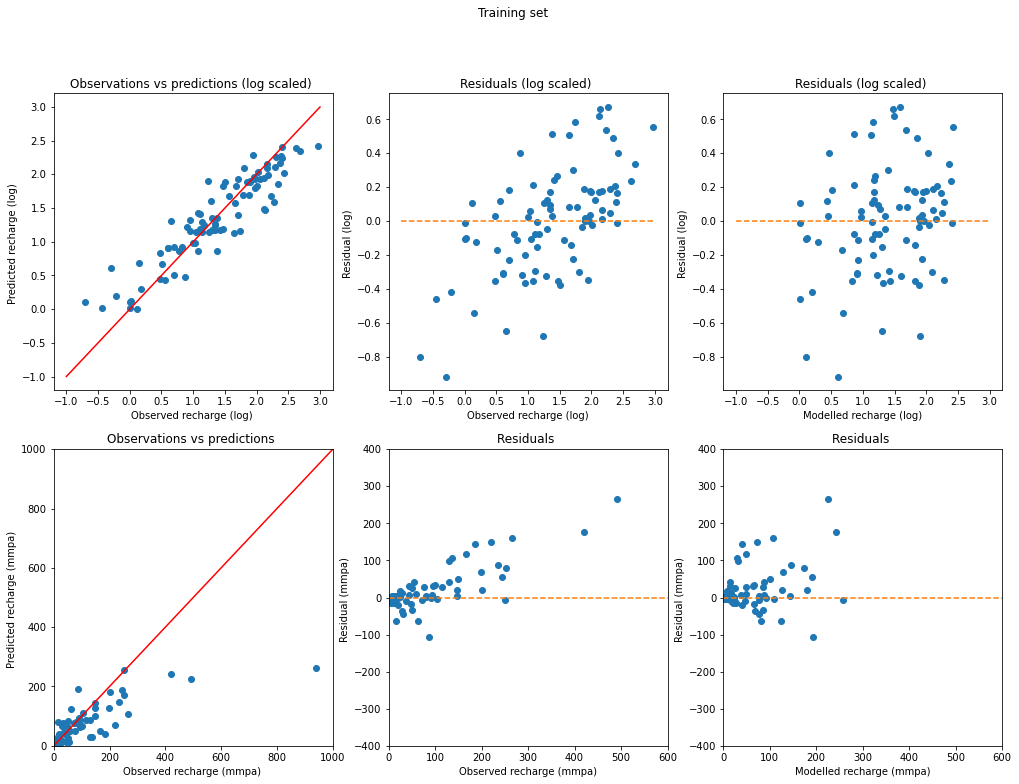

In [11]:
fig, axs = plt.subplots(2,3,figsize=(17,12))
fig.suptitle('Training set')
axs = axs.flatten()

axs[0].scatter(best_train_labels2, best_train_predictions2)
axs[0].plot(range(-1,4), range(-1,4), 'r')
#axs[0].plot(range(0,700), range(0,700), 'r')
axs[0].set_title('Observations vs predictions (log scaled) ')
axs[0].set_xlabel('Observed recharge (log) ')
axs[0].set_ylabel('Predicted recharge (log) ')
#axs[0].set_xlim([0,700])
#axs[0].set_ylim([0,700])

axs[1].plot(best_train_labels2, best_train_labels2 - best_train_predictions2,marker='o',linestyle='')
axs[1].plot(range(-1,4), np.zeros((5,)), '--')
#axs[1].plot(range(0,450), np.zeros((450,)), '--')
axs[1].set_title('Residuals (log scaled) ')
axs[1].set_xlabel('Observed recharge (log)')
axs[1].set_ylabel('Residual (log) ')
#axs[1].set_xlim([0,450])
#axs[1].set_ylim([-450,450])

axs[2].plot(best_train_predictions2, best_train_labels2 - best_train_predictions2,marker='o',linestyle='')
axs[2].plot(range(-1,4), np.zeros((5,)), '--')
#axs[2].plot(range(0,450), np.zeros((450,)), '--')
axs[2].set_title('Residuals (log scaled) ')
axs[2].set_xlabel('Modelled recharge (log)')
axs[2].set_ylabel('Residual (log) ')
#axs[2].set_xlim([0,450])
#axs[2].set_ylim([-450,450])

axs[3].scatter(10**best_train_labels2, 10**best_train_predictions2)
#axs[3].plot(range(-1,4), range(-1,4), 'r')
axs[3].plot(range(0,1000), range(0,1000), 'r')
axs[3].set_title('Observations vs predictions ')
axs[3].set_xlabel('Observed recharge (mmpa) ')
axs[3].set_ylabel('Predicted recharge (mmpa) ')
axs[3].set_xlim([0,1000])
axs[3].set_ylim([0,1000])

axs[4].plot(10**best_train_labels2, 10**best_train_labels2 - 10**best_train_predictions2,marker='o',linestyle='')
axs[4].plot(range(0,1000), np.zeros((1000,)), '--')
axs[4].set_title('Residuals ')
axs[4].set_xlabel('Observed recharge (mmpa)')
axs[4].set_ylabel('Residual (mmpa) ')
axs[4].set_xlim([0,600])
axs[4].set_ylim([-400,400])

axs[5].plot(10**best_train_predictions2, 10**best_train_labels2 - 10**best_train_predictions2,marker='o',linestyle='')
axs[5].plot(range(0,1000), np.zeros((1000,)), '--')
axs[5].set_title('Residuals ')
axs[5].set_xlabel('Modelled recharge (mmpa)')
axs[5].set_ylabel('Residual (mmpa) ')
axs[5].set_xlim([0,600])
axs[5].set_ylim([-400,400])

# n_bins = 10
# axs[2].hist(train_labels, bins=n_bins)
# axs[2].set_title('Distribution of observed recharge in the training set (scaled) ')
# axs[2].set_xlabel('Observed recharge (log10) ')
# axs[2].set_ylabel('Number of observations')
# axs[2].set_xlim([-1,3])
# #axs[2].set_ylim([0,25])

fig.savefig('res_training_2.jpg')

## NEW AVG

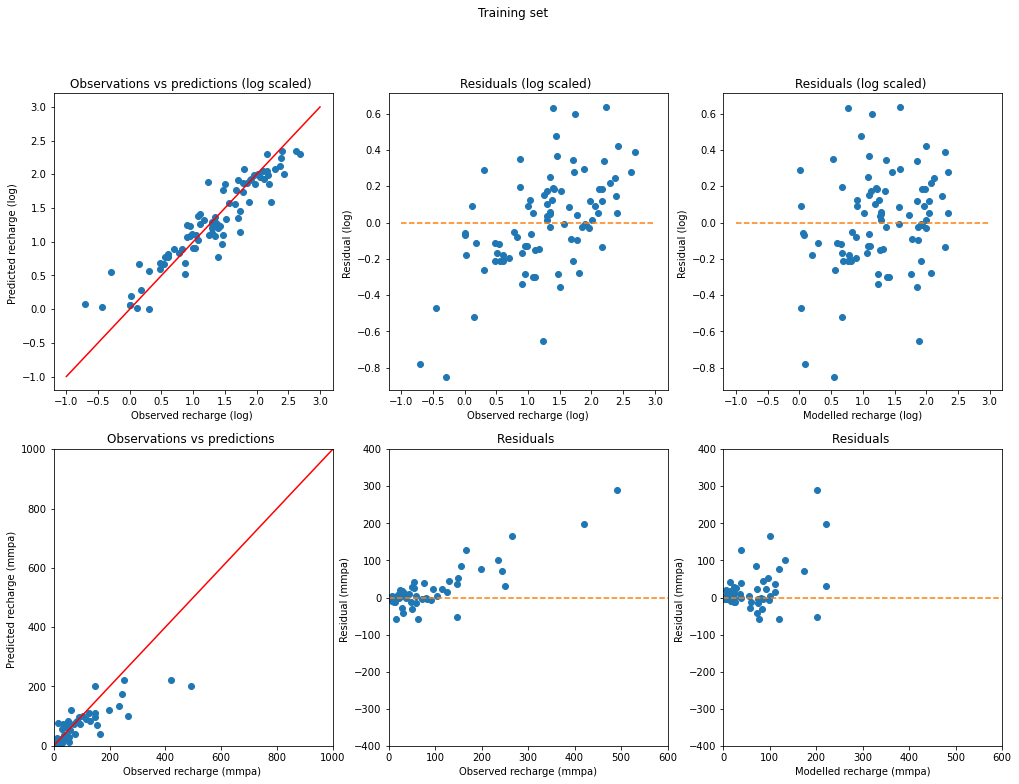

In [6]:
avg_predictions2 = avg_model.predict(avg_test_features2[:,important_indices])
# Use the forest's predict method on the training data
avg_train_predictions2 = avg_model.predict(avg_train_features2[:,important_indices])

fig, axs = plt.subplots(2,3,figsize=(17,12))
fig.suptitle('Training set')
axs = axs.flatten()

axs[0].scatter(avg_train_labels2, avg_train_predictions2)
axs[0].plot(range(-1,4), range(-1,4), 'r')
#axs[0].plot(range(0,700), range(0,700), 'r')
axs[0].set_title('Observations vs predictions (log scaled) ')
axs[0].set_xlabel('Observed recharge (log) ')
axs[0].set_ylabel('Predicted recharge (log) ')
#axs[0].set_xlim([0,700])
#axs[0].set_ylim([0,700])

axs[1].plot(avg_train_labels2, avg_train_labels2 - avg_train_predictions2,marker='o',linestyle='')
axs[1].plot(range(-1,4), np.zeros((5,)), '--')
#axs[1].plot(range(0,450), np.zeros((450,)), '--')
axs[1].set_title('Residuals (log scaled) ')
axs[1].set_xlabel('Observed recharge (log)')
axs[1].set_ylabel('Residual (log) ')
#axs[1].set_xlim([0,450])
#axs[1].set_ylim([-450,450])

axs[2].plot(avg_train_predictions2, avg_train_labels2 - avg_train_predictions2,marker='o',linestyle='')
axs[2].plot(range(-1,4), np.zeros((5,)), '--')
#axs[2].plot(range(0,450), np.zeros((450,)), '--')
axs[2].set_title('Residuals (log scaled) ')
axs[2].set_xlabel('Modelled recharge (log)')
axs[2].set_ylabel('Residual (log) ')
#axs[2].set_xlim([0,450])
#axs[2].set_ylim([-450,450])

axs[3].scatter(10**avg_train_labels2, 10**avg_train_predictions2)
#axs[3].plot(range(-1,4), range(-1,4), 'r')
axs[3].plot(range(0,1000), range(0,1000), 'r')
axs[3].set_title('Observations vs predictions ')
axs[3].set_xlabel('Observed recharge (mmpa) ')
axs[3].set_ylabel('Predicted recharge (mmpa) ')
axs[3].set_xlim([0,1000])
axs[3].set_ylim([0,1000])

axs[4].plot(10**avg_train_labels2, 10**avg_train_labels2 - 10**avg_train_predictions2,marker='o',linestyle='')
axs[4].plot(range(0,1000), np.zeros((1000,)), '--')
axs[4].set_title('Residuals ')
axs[4].set_xlabel('Observed recharge (mmpa)')
axs[4].set_ylabel('Residual (mmpa) ')
axs[4].set_xlim([0,600])
axs[4].set_ylim([-400,400])

axs[5].plot(10**avg_train_predictions2, 10**avg_train_labels2 - 10**avg_train_predictions2,marker='o',linestyle='')
axs[5].plot(range(0,1000), np.zeros((1000,)), '--')
axs[5].set_title('Residuals ')
axs[5].set_xlabel('Modelled recharge (mmpa)')
axs[5].set_ylabel('Residual (mmpa) ')
axs[5].set_xlim([0,600])
axs[5].set_ylim([-400,400])

# n_bins = 10
# axs[2].hist(train_labels, bins=n_bins)
# axs[2].set_title('Distribution of observed recharge in the training set (scaled) ')
# axs[2].set_xlabel('Observed recharge (log10) ')
# axs[2].set_ylabel('Number of observations')
# axs[2].set_xlim([-1,3])
# #axs[2].set_ylim([0,25])

fig.savefig('res_training_2.jpg')

In [12]:
print('=== Testing set metrics ===')
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(best_test_labels2, best_predictions2))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(best_test_labels2, best_predictions2))
print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(best_test_labels2, best_predictions2, squared=False))
print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(best_test_labels2, best_predictions2))
print('Explained Variance Score:', metrics.explained_variance_score(best_test_labels2, best_predictions2))
print('Max Error:', metrics.max_error(best_test_labels2, best_predictions2))
print('R^2:', metrics.r2_score(best_test_labels2, best_predictions2))

print('=== after back transformation ===')
print('R^2:', metrics.r2_score(10**best_test_labels2, 10**best_predictions2))

=== Testing set metrics ===
Mean Absolute Error (MAE): 0.24748574010759442
Mean Squared Error (MSE): 0.11295034901260469
Root Mean Squared Error (RMSE): 0.33608086677554955
Mean Absolute Percentage Error (MAPE): 0.35712015857675233
Explained Variance Score: 0.6648309281332234
Max Error: 1.0098679665840522
R^2: 0.6641149721077823
=== after back transformation ===
R^2: 0.5524666719371675


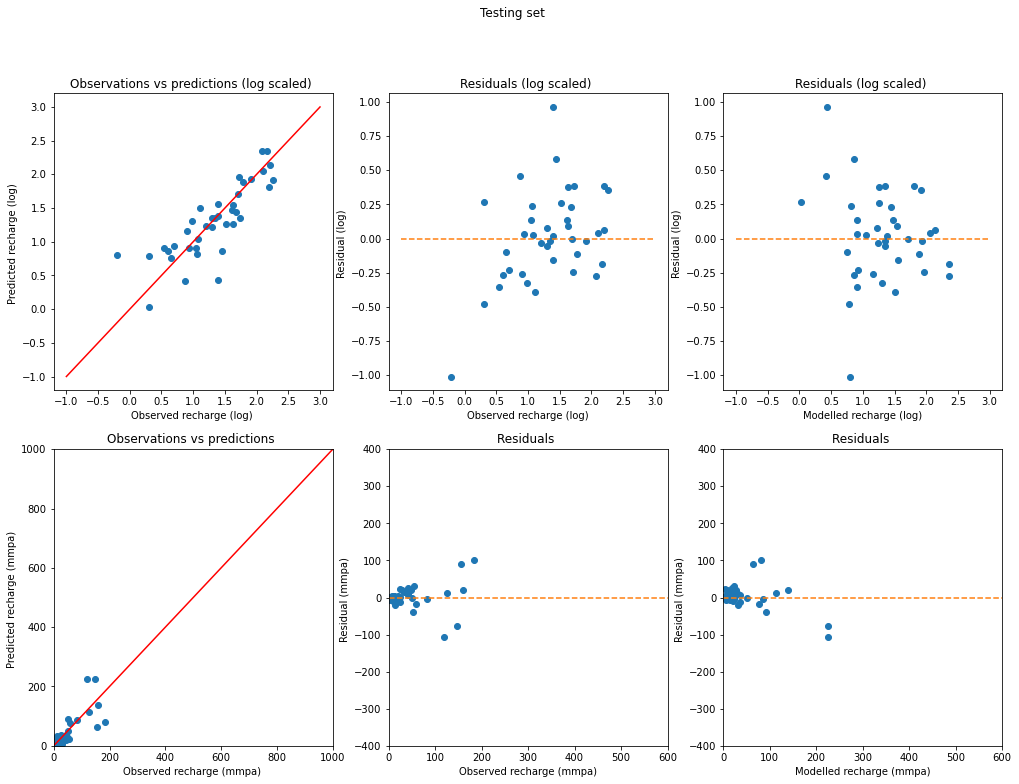

In [13]:
fig, axs = plt.subplots(2,3,figsize=(17,12))
fig.suptitle('Testing set')
axs = axs.flatten()

axs[0].scatter(best_test_labels2, best_predictions2)
axs[0].plot(range(-1,4), range(-1,4), 'r')
#axs[0].plot(range(0,700), range(0,700), 'r')
axs[0].set_title('Observations vs predictions (log scaled) ')
axs[0].set_xlabel('Observed recharge (log) ')
axs[0].set_ylabel('Predicted recharge (log) ')
#axs[0].set_xlim([0,700])
#axs[0].set_ylim([0,700])

axs[1].plot(best_test_labels2, best_test_labels2 - best_predictions2,marker='o',linestyle='')
axs[1].plot(range(-1,4), np.zeros((5,)), '--')
#axs[1].plot(range(0,450), np.zeros((450,)), '--')
axs[1].set_title('Residuals (log scaled) ')
axs[1].set_xlabel('Observed recharge (log)')
axs[1].set_ylabel('Residual (log) ')
#axs[1].set_xlim([0,450])
#axs[1].set_ylim([-450,450])

axs[2].plot(best_predictions2, best_test_labels2 - best_predictions2,marker='o',linestyle='')
axs[2].plot(range(-1,4), np.zeros((5,)), '--')
#axs[2].plot(range(0,450), np.zeros((450,)), '--')
axs[2].set_title('Residuals (log scaled) ')
axs[2].set_xlabel('Modelled recharge (log)')
axs[2].set_ylabel('Residual (log) ')
#axs[2].set_xlim([0,450])
#axs[2].set_ylim([-450,450])

axs[3].scatter(10**best_test_labels2, 10**best_predictions2)
#axs[3].plot(range(-1,4), range(-1,4), 'r')
axs[3].plot(range(0,1000), range(0,1000), 'r')
axs[3].set_title('Observations vs predictions ')
axs[3].set_xlabel('Observed recharge (mmpa) ')
axs[3].set_ylabel('Predicted recharge (mmpa) ')
axs[3].set_xlim([0,1000])
axs[3].set_ylim([0,1000])

axs[4].plot(10**best_test_labels2, 10**best_test_labels2 - 10**best_predictions2,marker='o',linestyle='')
axs[4].plot(range(0,1000), np.zeros((1000,)), '--')
axs[4].set_title('Residuals ')
axs[4].set_xlabel('Observed recharge (mmpa)')
axs[4].set_ylabel('Residual (mmpa) ')
axs[4].set_xlim([0,600])
axs[4].set_ylim([-400,400])

axs[5].plot(10**best_predictions2, 10**best_test_labels2 - 10**best_predictions2,marker='o',linestyle='')
axs[5].plot(range(0,1000), np.zeros((1000,)), '--')
axs[5].set_title('Residuals ')
axs[5].set_xlabel('Modelled recharge (mmpa)')
axs[5].set_ylabel('Residual (mmpa) ')
axs[5].set_xlim([0,600])
axs[5].set_ylim([-400,400])

# n_bins = 10
# axs[2].hist(test_labels, bins=n_bins)
# axs[2].set_title('Distribution of observed recharge in the testing set (scaled) ')
# axs[2].set_xlabel('Observed recharge (log10) ')
# axs[2].set_ylabel('Number of observations')
# axs[2].set_xlim([-1,3])

fig.savefig('res_testing_2.jpg')

## NEW AVG

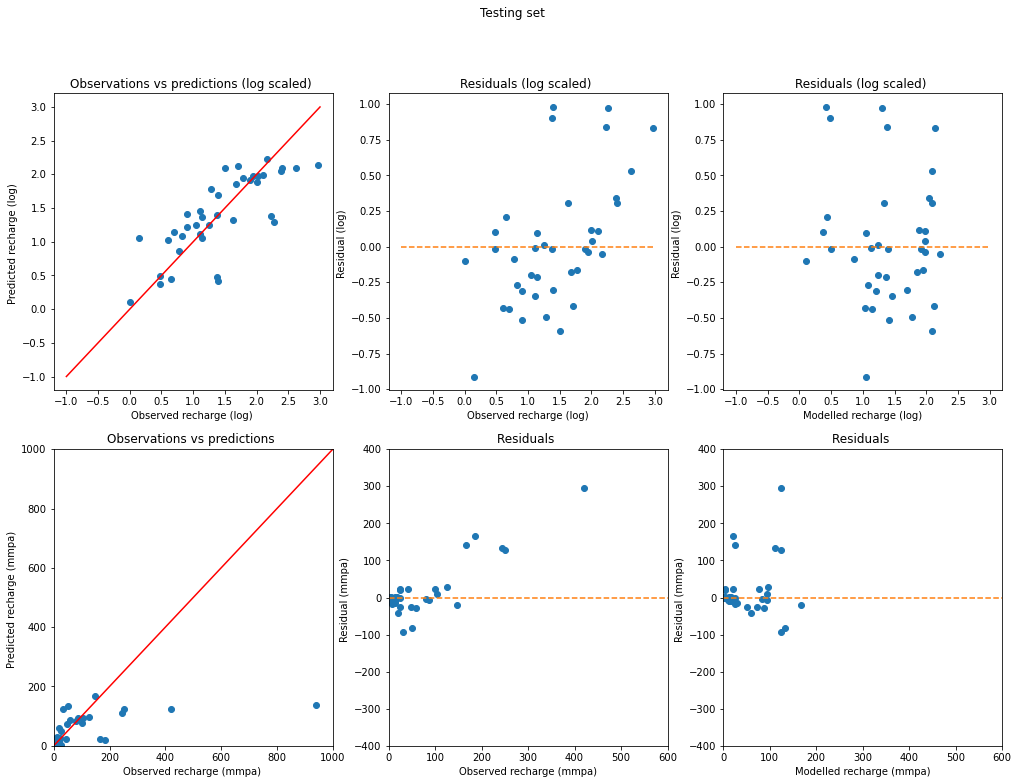

In [29]:
fig, axs = plt.subplots(2,3,figsize=(17,12))
fig.suptitle('Testing set')
axs = axs.flatten()

axs[0].scatter(avg_test_labels2, avg_predictions2)
axs[0].plot(range(-1,4), range(-1,4), 'r')
#axs[0].plot(range(0,700), range(0,700), 'r')
axs[0].set_title('Observations vs predictions (log scaled) ')
axs[0].set_xlabel('Observed recharge (log) ')
axs[0].set_ylabel('Predicted recharge (log) ')
#axs[0].set_xlim([0,700])
#axs[0].set_ylim([0,700])

axs[1].plot(avg_test_labels2, avg_test_labels2 - avg_predictions2,marker='o',linestyle='')
axs[1].plot(range(-1,4), np.zeros((5,)), '--')
#axs[1].plot(range(0,450), np.zeros((450,)), '--')
axs[1].set_title('Residuals (log scaled) ')
axs[1].set_xlabel('Observed recharge (log)')
axs[1].set_ylabel('Residual (log) ')
#axs[1].set_xlim([0,450])
#axs[1].set_ylim([-450,450])

axs[2].plot(avg_predictions2, avg_test_labels2 - avg_predictions2,marker='o',linestyle='')
axs[2].plot(range(-1,4), np.zeros((5,)), '--')
#axs[2].plot(range(0,450), np.zeros((450,)), '--')
axs[2].set_title('Residuals (log scaled) ')
axs[2].set_xlabel('Modelled recharge (log)')
axs[2].set_ylabel('Residual (log) ')
#axs[2].set_xlim([0,450])
#axs[2].set_ylim([-450,450])

axs[3].scatter(10**avg_test_labels2, 10**avg_predictions2)
#axs[3].plot(range(-1,4), range(-1,4), 'r')
axs[3].plot(range(0,1000), range(0,1000), 'r')
axs[3].set_title('Observations vs predictions ')
axs[3].set_xlabel('Observed recharge (mmpa) ')
axs[3].set_ylabel('Predicted recharge (mmpa) ')
axs[3].set_xlim([0,1000])
axs[3].set_ylim([0,1000])

axs[4].plot(10**avg_test_labels2, 10**avg_test_labels2 - 10**avg_predictions2,marker='o',linestyle='')
axs[4].plot(range(0,1000), np.zeros((1000,)), '--')
axs[4].set_title('Residuals ')
axs[4].set_xlabel('Observed recharge (mmpa)')
axs[4].set_ylabel('Residual (mmpa) ')
axs[4].set_xlim([0,600])
axs[4].set_ylim([-400,400])

axs[5].plot(10**avg_predictions2, 10**avg_test_labels2 - 10**avg_predictions2,marker='o',linestyle='')
axs[5].plot(range(0,1000), np.zeros((1000,)), '--')
axs[5].set_title('Residuals ')
axs[5].set_xlabel('Modelled recharge (mmpa)')
axs[5].set_ylabel('Residual (mmpa) ')
axs[5].set_xlim([0,600])
axs[5].set_ylim([-400,400])

# n_bins = 10
# axs[2].hist(test_labels, bins=n_bins)
# axs[2].set_title('Distribution of observed recharge in the testing set (scaled) ')
# axs[2].set_xlabel('Observed recharge (log10) ')
# axs[2].set_ylabel('Number of observations')
# axs[2].set_xlim([-1,3])

fig.savefig('res_testing_2.jpg')

In [48]:
print(avg_model.score(avg_train_features2[:, important_indices], avg_train_labels2))
print(avg_model.score(avg_test_features2[:, important_indices], avg_test_labels2))
print(avg_model.oob_score_)

0.8489274176703452
0.5957134282399081
0.6896426111036973


In [58]:
df = pd.DataFrame(avg_test_features2, columns=['LTA_P_mmpa','LTA_PET_mm','Aridity','NDVI','Landcover_ext','DEM','SM10_m3m3','Aquifer_group_cat','Soil_group_cat'])
df['obs'] = 10**avg_test_labels2.values
df['pred']= 10**avg_predictions2
df

,LTA_P_mmpa,LTA_PET_mm,Aridity,NDVI,Landcover_ext,DEM,SM10_m3m3,Aquifer_group_cat,Soil_group_cat,obs,pred
0,192.303336,1301.140023,0.147831,0.252886,150.0,259.0,0.213693,2.0,6.0,14.0,11.282303
1,655.280013,1356.070025,0.486649,0.403724,30.0,1376.0,0.323871,1.0,10.0,100.0,75.767548
2,1662.830027,1033.480015,1.609934,0.731372,30.0,695.0,0.382144,0.0,7.0,87.0,94.789879
3,1111.413350,1433.746688,0.776586,0.502223,130.0,440.0,0.292811,0.0,10.0,51.0,132.845567
4,1507.256696,1045.840018,1.440693,0.613144,130.0,494.0,0.352199,0.0,0.0,420.0,123.679591
5,372.166672,1421.650028,0.262060,0.338183,140.0,1259.0,0.195870,1.0,2.0,1.4,11.382982
6,550.086676,1439.103357,0.383435,0.444569,130.0,989.0,0.202209,1.0,11.0,8.0,26.196609
7,477.643340,1393.103361,0.345251,0.368177,30.0,1118.0,0.209462,1.0,10.0,18.0,17.460937
8,2039.000026,1055.556683,1.932248,0.624046,130.0,1438.0,0.374726,0.0,20.0,251.0,123.835671
9,407.200007,1374.700031,0.297110,0.385771,30.0,1153.0,0.196534,1.0,3.0,4.0,10.713240
